In [1]:
# Instalar pacotes necessários
%pip install -q pandas numpy scikit-learn matplotlib seaborn wordcloud nltk tqdm ollama networkx tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Processa verificação gramática das mensagens usando Ollama
import os
from scripts.translate import translation

input_csv = 'data/spam.csv'
output_csv = 'data/spam_br.csv'

if not os.path.exists(output_csv):
    translation(input_csv, output_csv) 
else:
    print(f'O arquivo {output_csv} já existe.')

O arquivo data/spam_br.csv já existe.


In [3]:
# Leitura dos dados
import pandas as pd

spam = pd.read_csv('data/spam_br.csv', encoding='utf-8')
spam = spam[['Label', 'EmailTextBR']]
spam.columns = ['label', 'sms']
print(f'Linhas da base SPAM original: {spam.shape}')
spam.head()

Linhas da base SPAM original: (5572, 2)


,label,sms
0,ham,"Vá até o ponto de Jurong, louco. Disponível so..."
1,ham,Ok lábio... Jogando com você...
2,spam,Entrada gratuita em 2 compilações semanais par...
3,ham,"U deu dizer assim cedo... U já está, então diz..."
4,ham,"Não acho que ele vai para usf, mas vive aqui p..."


In [4]:
# Estatísticas básicas
spam['word_count'] = spam['sms'].apply(lambda x: len(x.split()))
spam['char_count'] = spam['sms'].apply(len)

# Contar mensagens por categoria (ham/spam)
sms_by_label = spam['label'].value_counts().to_frame(name='Número de SMS')
sms_by_label.index.name = 'label'

# Média de palavras por mensagem
words_by_sms = spam.groupby('label')['word_count'].mean().to_frame(name='Média palavras por SMS')

# Juntar os dois DataFrames
sms_by_label.join(words_by_sms)

,Número de SMS,Média palavras por SMS
label,,
ham,4825,14.327254
spam,747,27.551539


In [5]:
# Maiores e menores SMSs
maiores = spam.sort_values(by='char_count', ascending=False).head(5)
menores = spam.sort_values(by='char_count', ascending=True).head(5)
maiores_menores = pd.concat([maiores, menores], axis=0)
maiores_menores[['label', 'char_count', 'word_count', 'sms']].reset_index(drop=True)

,label,char_count,word_count,sms
0,ham,1012,185,For eu o amor deve começar com atracção. Eu de...
1,ham,838,156,O último que eu queria fazer era te machucar. ...
2,ham,723,121,Triste história de um homem - A semana passada...
3,ham,723,121,Triste história de um homem - A semana passada...
4,ham,667,117,"Indígenas são pobres, mas a Índia não é uma po..."
5,ham,2,1,:)
6,ham,2,1,Ok
7,spam,2,1,OK
8,ham,2,1,Ok
9,ham,2,1,Ok


In [37]:
# Conta total de palavras distintas
palavras_distintas = set()

for sms in spam['sms']:
    palavras = sms.lower().split()
    palavras_distintas.update(palavras)

print(f"Número de palavras distintas: {len(palavras_distintas)}")

Número de palavras distintas: 15107


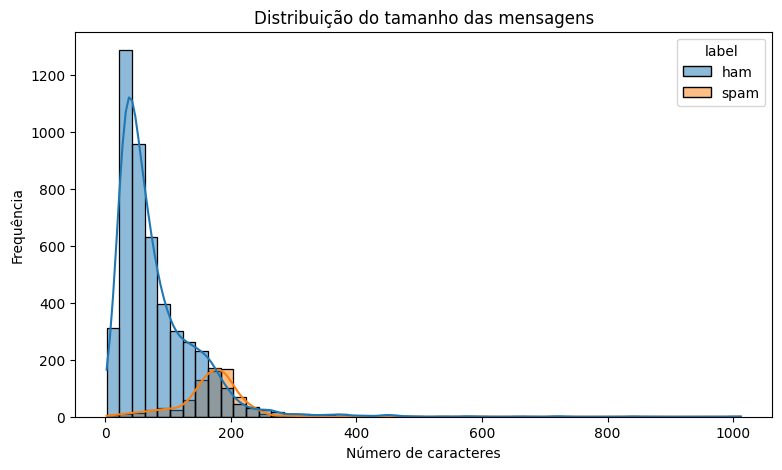

In [ ]:
# Histograma do comprimento das mensagens
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9,5))
sns.histplot(data=spam, x='char_count', hue='label', bins=50, kde=True)
plt.title('Distribuição do tamanho das mensagens')
plt.xlabel('Número de caracteres')
plt.ylabel('Frequência')
plt.savefig('figures/histograma.png')
plt.show()

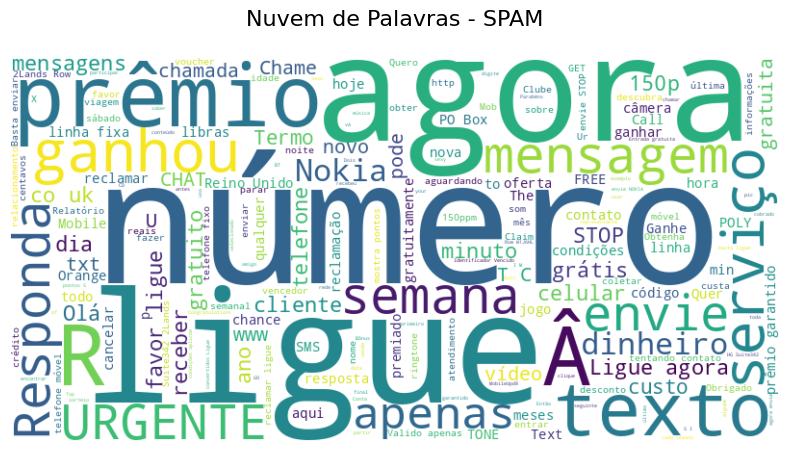

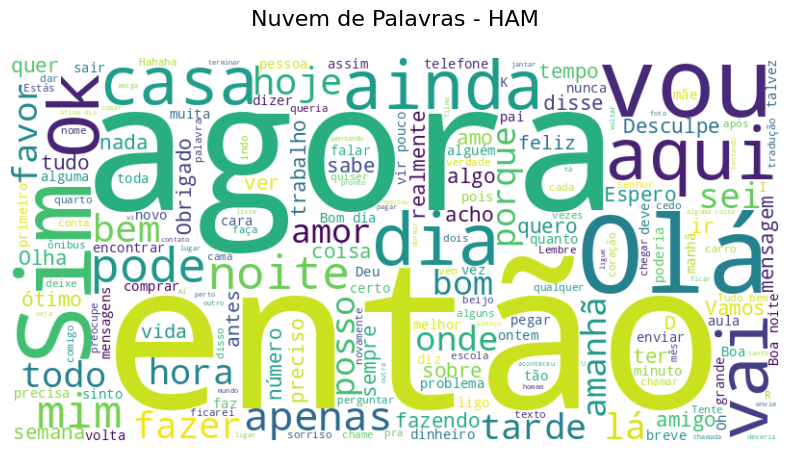

In [8]:
# Nuvem de palavras
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud  

nltk.download('stopwords', quiet=True)

def generate_wordcloud(text, title, save_path=None):
    # Obtém stopwords em português
    stopwords_pt = set(stopwords.words('portuguese'))
    
    # Gera a nuvem de palavras
    wc = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords_pt).generate(text)
    
    # Cria a figura
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    
    # Salva
    if save_path:
        plt.savefig(save_path)

    # Exibe
    plt.show()


spam_text = ' '.join(spam[spam['label'] == 'spam']['sms'])
ham_text = ' '.join(spam[spam['label'] == 'ham']['sms'])

generate_wordcloud(spam_text, 'Nuvem de Palavras - SPAM\n', save_path='figures/nuvem_palavras_spam.png')
generate_wordcloud(ham_text, 'Nuvem de Palavras - HAM\n', save_path='figures/nuvem_palavras_ham.png')

Total de palavras distintas em SPAM (após limpeza): 2422
Total de palavras distintas em HAM (após limpeza): 7165


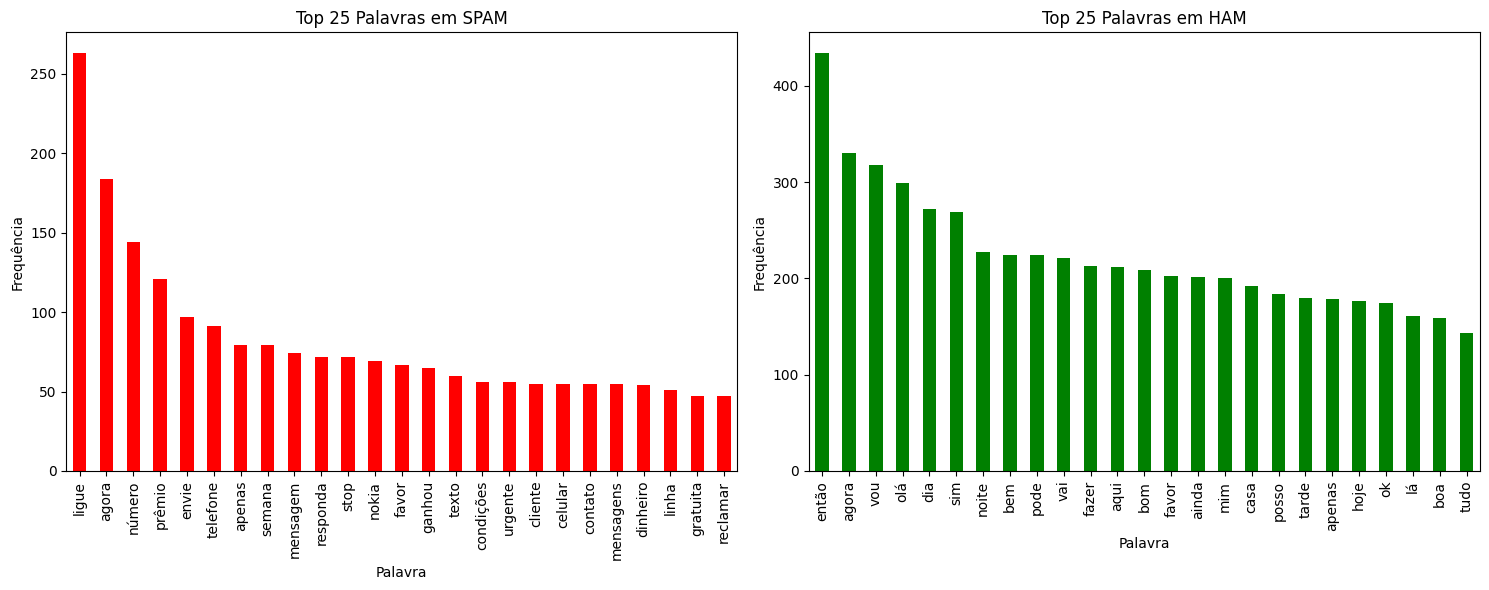

In [38]:
# Frequência de palavras
from collections import Counter

# Baixar recursos do NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Função de limpeza e tokenização
def get_word_frequencies(text_series):
    stop_words = set(stopwords.words('portuguese'))
    all_words = []
    for message in text_series:
        # Tokenizar em palavras, normalizar e filtrar
        words = nltk.word_tokenize(message.lower())
        words = [word for word in words if word.isalpha() and word not in stop_words and len(word) > 1]
        all_words.extend(words)
    return Counter(all_words), set(all_words)  # Retorna também o conjunto de palavras únicas

# Frequências e vocabulário para SPAM
spam_freq, spam_vocab = get_word_frequencies(spam[spam['label'] == 'spam']['sms'])

# Frequências e vocabulário para HAM
ham_freq, ham_vocab = get_word_frequencies(spam[spam['label'] == 'ham']['sms'])

# Total de palavras distintas (sem stopwords e pontuação)
print(f"Total de palavras distintas em SPAM (após limpeza): {len(spam_vocab)}")
print(f"Total de palavras distintas em HAM (após limpeza): {len(ham_vocab)}")

# Transformar as frequências em DataFrame para visualização
common_words = 25
spam_df = pd.DataFrame(spam_freq.most_common(common_words), columns=["Palavra", "Frequência"])
ham_df = pd.DataFrame(ham_freq.most_common(common_words), columns=["Palavra", "Frequência"])

# Gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras para SPAM
spam_df.plot(kind='bar', x='Palavra', y='Frequência', ax=ax1, color='red', legend=False)
ax1.set_title(f'Top {common_words} Palavras em SPAM')
ax1.set_xlabel('Palavra')
ax1.set_ylabel('Frequência')

# Gráfico de barras para HAM
ham_df.plot(kind='bar', x='Palavra', y='Frequência', ax=ax2, color='green', legend=False)
ax2.set_title(f'Top {common_words} Palavras em HAM')
ax2.set_xlabel('Palavra')
ax2.set_ylabel('Frequência')

plt.tight_layout()
plt.savefig('figures/top_25_palavras.png')
plt.show()

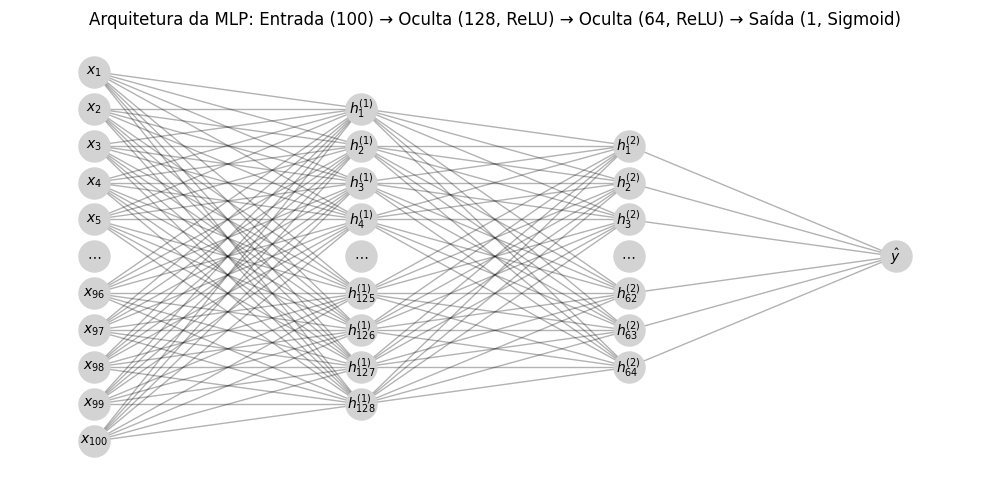

In [23]:
# Arquitetura planejada
import networkx as nx

# Versão reduzida e ilustrativa da arquitetura real
def insert_ellipsis(layer, prefix, total_nodes):
    half = len(layer) // 2
    return (
        [f'{prefix}_{{{i+1}}}' for i in range(half)]
        + ['ellipsis']
        + [f'{prefix}_{{{total_nodes - half + i}}}' for i in range(half)]
    )

# Camadas com reticências inseridas
input_layer = insert_ellipsis([None]*10, 'x', 101)             # Entrada: 100 tokens (exibindo 10)
hidden_layer1 = insert_ellipsis([None]*8, 'h^{{(1)}}', 129)    # Oculta 1: 128 neurônios
hidden_layer2 = insert_ellipsis([None]*6, 'h^{{(2)}}', 65)     # Oculta 2: 64 neurônios
output_layer = [r'\hat{y}']                                    # Saída: 1 nó

layers = [input_layer, hidden_layer1, hidden_layer2, output_layer]

# Criar grafo
G = nx.DiGraph()
positions = {}
labels = {}

layer_dist = 2.5
node_dist = 1.0

for i, layer in enumerate(layers):
    offset = (max(len(l) for l in layers) - len(layer)) / 2
    for j, node in enumerate(layer):
        is_ellipsis = node == 'ellipsis'
        node_name = f'{i}_{j}' if is_ellipsis else node
        G.add_node(node_name)
        y_pos = -(j + offset) * node_dist
        positions[node_name] = (i * layer_dist, y_pos)
        labels[node_name] = r"$\cdots$" if is_ellipsis else f"${node}$"

# Conexão entre camadas (pulando reticências)
def connect_layers(layer1, layer2, i1, i2):
    for u_j, u in enumerate(layer1):
        if u == 'ellipsis': continue
        u_name = f'{i1}_{u_j}' if u == 'ellipsis' else u
        for v_j, v in enumerate(layer2):
            if v == 'ellipsis': continue
            v_name = f'{i2}_{v_j}' if v == 'ellipsis' else v
            G.add_edge(u_name, v_name)

connect_layers(input_layer, hidden_layer1, 0, 1)
connect_layers(hidden_layer1, hidden_layer2, 1, 2)
connect_layers(hidden_layer2, output_layer, 2, 3)

# Desenho
plt.figure(figsize=(10, 5))
nx.draw_networkx_nodes(G, positions, node_color='lightgray', node_size=500)
nx.draw_networkx_edges(G, positions, arrows=False, alpha=0.3, width=1)
nx.draw_networkx_labels(G, positions, labels, font_size=10)

plt.title('Arquitetura da MLP: Entrada (100) → Oculta (128, ReLU) → Oculta (64, ReLU) → Saída (1, Sigmoid)', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/arquitetura.png')
plt.show()

In [ ]:
# Bibliotecas usadas para o treinamento
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC, Precision, Recall
import pickle
import os

In [26]:
# Codificação dos rótulos (ham = 0, spam = 1)
le = LabelEncoder()
spam['label_enc'] = le.fit_transform(spam['label'])
spam.head()

,label,sms,word_count,char_count,label_enc
0,ham,"Vá até o ponto de Jurong, louco. Disponível so...",19,108,0
1,ham,Ok lábio... Jogando com você...,5,31,0
2,spam,Entrada gratuita em 2 compilações semanais par...,41,241,1
3,ham,"U deu dizer assim cedo... U já está, então diz...",10,49,0
4,ham,"Não acho que ele vai para usf, mas vive aqui p...",11,51,0


In [36]:
# Divisão estratificada: 80% treino, 10% validação, 10% teste
X_temp, X_test, y_temp, y_test = train_test_split(
    spam['sms'], spam['label_enc'], test_size=0.10, stratify=spam['label_enc'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)  # 0.1111 de 90% ≈ 10%

print('Dados de treinamento', X_train.shape)
print('Dados de validação', X_val.shape)
print('Dados de teste', X_test.shape)

Dados de treinamento (4456,)
Dados de validação (558,)
Dados de teste (558,)


In [62]:
# Tokenização
tokenizador_file = 'model/tokenizer.pkl'

if os.path.exists(tokenizador_file):
    # Abrir o arquivo e carregar
    print('Tokenizador existente encontrado. Carregando...')
    with open(tokenizador_file, 'rb') as f:
        tokenizer = pickle.load(f)
else:
    print('Criando tokenizador...')
    max_words = 10000
    maxlen = 200

    tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Salvar o tokenizador
    os.makedirs('model', exist_ok=True)  # Garantir que a pasta exista
    with open(tokenizador_file, 'wb') as f:
        pickle.dump(tokenizer, f)
    print(f'Tokenizador salvo em: {tokenizador_file}')

# Transformar textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Aplicar padding
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

# Determinar o número real de palavras (pode ser < max_words)
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

# print(f'Word index = {word_index}')
print(f'Palavras = {num_words}')

Tokenizador existente encontrado. Carregando...
Palavras = 8861


In [76]:
# Construção do modelo MLP com embedding treinável, seguindo a estrutura
# Entrada (100) → Pooling → Oculta (128, ReLU) → Dropout → Oculta (64, ReLU) → Dropout → Saída (1, Sigmoid)
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(input_dim=num_words, output_dim=100, trainable=True),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Saída binária
])

# Configuração do otimizador
optimizer = Adam(learning_rate=0.0001)

# Métricas para acompanhamento
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]
)

# Sumário do modelo
model.build(input_shape=(None, maxlen))
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 200, 100)       │       886,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_13     │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 907,349 (3.46 MB)

 Trainable params: 907,349 (3.46 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Cálculo dos pesos das classes (balanceamento do desbalanceamento)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))
print('Pesos {0 = HAM, 1 = SPAM} ] =', class_weights_dict)

Pesos {0 = HAM, 1 = SPAM} ] = {0: 0.5773516455040166, 1: 3.731993299832496}


Treinando novo modelo MLP...
Epoch 1/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 20s 536ms/step - accuracy: 0.6376 - auc: 0.4930 - loss: 0.6774 - precision: 0.1257 - recall: 0.3101 - val_accuracy: 0.8656 - val_auc: 0.4948 - val_loss: 0.6710 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 507ms/step - accuracy: 0.7065 - auc: 0.5467 - loss: 0.6995 - precision: 0.1456 - recall: 0.2326 - val_accuracy: 0.8656 - val_auc: 0.4969 - val_loss: 0.6694 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 518ms/step - accuracy: 0.7325 - auc: 0.5332 - loss: 0.6920 - precision: 0.1218 - recall: 0.1628 - val_accuracy: 0.8656 - val_auc: 0.7919 - val_loss: 0.6533 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
35/35 ━━━━━━━━━━━━━━━━━━━━ 18s 518ms/step - accuracy: 0.7805 - auc: 0.5306 - loss: 0.6889 - precision: 0.1216 - recall: 0.1061 - val_accuracy: 0.8656 - val_auc: 0.7668 - val_loss: 0.6546 - val_precision: 0.0

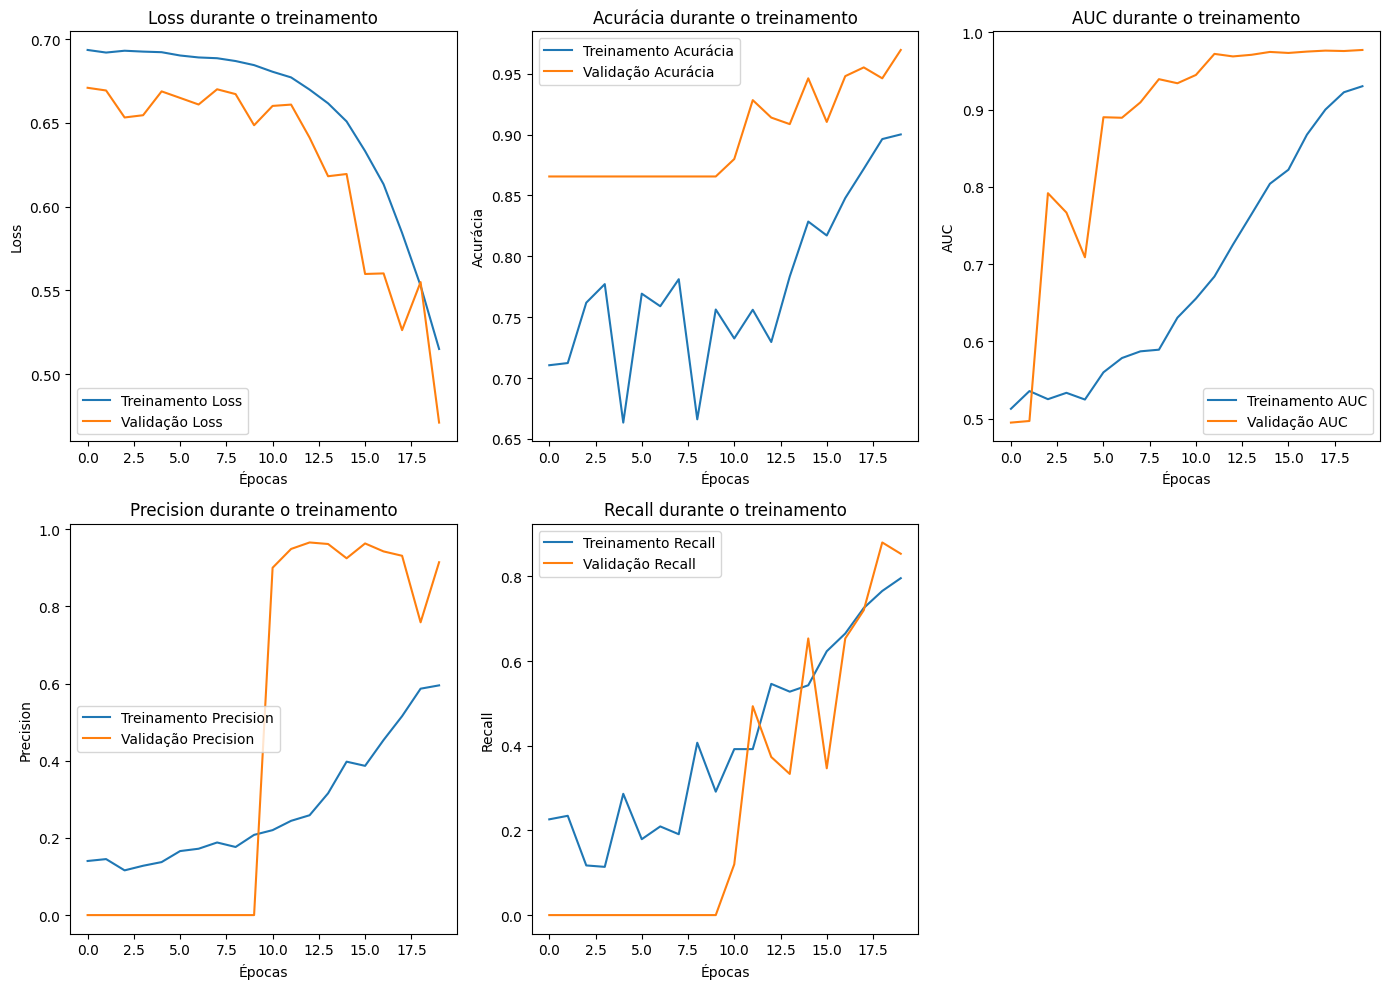

In [78]:
# Treinamento com EarlyStopping ou carregamento do modelo salvo
model_file = 'model/spam.keras'

if os.path.exists(model_file):
    print('Modelo já existente encontrado. Carregando...')
    model = load_model(model_file)
else:
    print('Treinando novo modelo MLP...')
    es = EarlyStopping(patience=7, restore_best_weights=True)

    # Definindo as métricas
    metrics = ['accuracy', AUC(name='auc'), Precision(name='precision'), Recall(name='recall')]

    history = model.fit(
        X_train_pad, y_train,
        validation_data=(X_val_pad, y_val),
        epochs=20,
        batch_size=128,
        callbacks=[es],
        class_weight=class_weights_dict,
    )

    # Criar pasta se não existir
    os.makedirs(os.path.dirname(model_file), exist_ok=True)

    # Salvar o modelo treinado
    model.save(model_file)
    print(f'Modelo salvo em: {model_file}')

# Plotando gráficos
plt.figure(figsize=(14, 10))

# Gráfico de Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Treinamento Loss')
plt.plot(history.history['val_loss'], label='Validação Loss')
plt.title('Loss durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

# Gráfico de Acurácia
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Treinamento Acurácia')
plt.plot(history.history['val_accuracy'], label='Validação Acurácia')
plt.title('Acurácia durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico de AUC (Área sob a Curva)
plt.subplot(2, 3, 3)
plt.plot(history.history['auc'], label='Treinamento AUC')
plt.plot(history.history['val_auc'], label='Validação AUC')
plt.title('AUC durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('AUC')
plt.legend()

# Gráfico de Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Treinamento Precision')
plt.plot(history.history['val_precision'], label='Validação Precision')
plt.title('Precision durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Precision')
plt.legend()

# Gráfico de Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Treinamento Recall')
plt.plot(history.history['val_recall'], label='Validação Recall')
plt.title('Recall durante o treinamento')
plt.xlabel('Épocas')
plt.ylabel('Recall')
plt.legend()


# Exibir gráficos
plt.tight_layout()
plt.savefig('figures/treinamento.png')
plt.show()

In [ ]:

















# 8. Recarregar o modelo salvo
modelo_carregado = load_model('modelo_mlp_spam.h5')

# 9. Recarregar o tokenizador salvo
with open('tokenizer.pkl', 'rb') as f:
    tokenizer_carregado = pickle.load(f)

# 10. Testar o modelo carregado
X_test_seq_loaded = tokenizer_carregado.texts_to_sequences(X_test)
X_test_pad_loaded = pad_sequences(X_test_seq_loaded, maxlen=maxlen)
y_pred_loaded = (modelo_carregado.predict(X_test_pad_loaded) > 0.5).astype(int)

# Relatório completo de classificação
print(classification_report(y_test, y_pred_loaded, target_names=le.classes_))


/Users/thyarles/SPAI/unb-pca-spamdetector/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-07-17 15:45:37.631831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.6762 - loss: 0.6893 - val_accuracy: 0.8638 - val_loss: 0.5427
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.8447 - loss: 0.5361 - val_accuracy: 0.7527 - val_loss: 0.5190
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.8916 - loss: 0.2459 - val_accuracy: 0.9731 - val_loss: 0.0924
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9709 - loss: 0.1510 - val_accuracy: 0.9606 - val_loss: 0.1311
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9209 - loss: 0.2083 - val_accuracy: 0.9731 - val_loss: 0.0833
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9786 - loss: 0.1172 - val_accuracy: 0.9606 - val_loss: 0.1116
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.9741 - loss: 0.0997 - val_accuracy: 0.9606 - val_loss: 0.1621
Epoch 8/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9830 - loss: 0.1108 - val_accuracy: 0.97

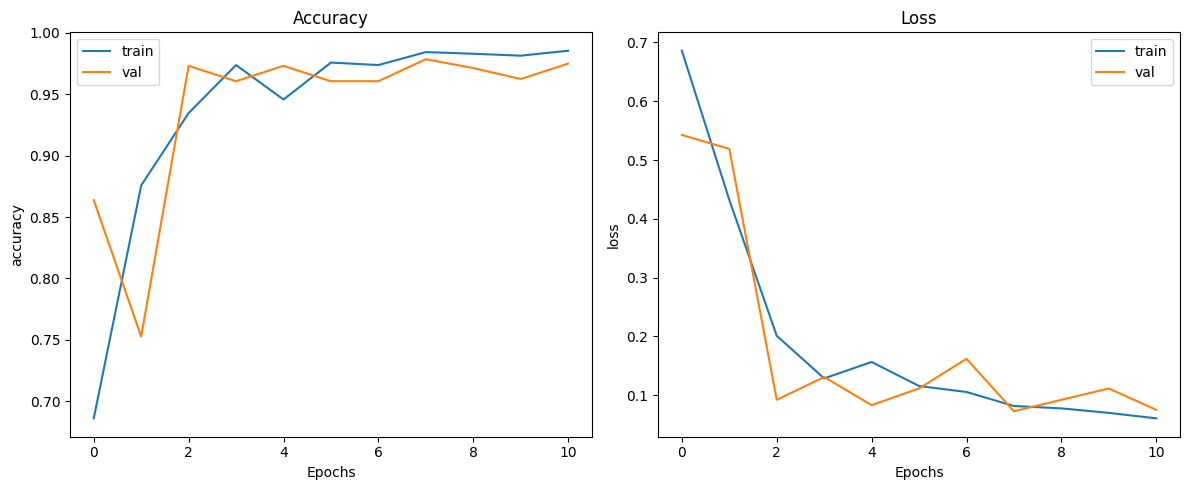

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       483
        spam       0.97      0.88      0.92        75

    accuracy                           0.98       558
   macro avg       0.98      0.94      0.96       558
weighted avg       0.98      0.98      0.98       558

Matriz de confusão:
 [[481   2]
 [  9  66]]


/Users/thyarles/SPAI/unb-pca-spamdetector/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Validação cruzada 5-fold - Acurácia média: 0.9770 ± 0.0020


In [ ]:
# 1. Importações
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

# 2. Preparar dados
le = LabelEncoder()
spam['label_enc'] = le.fit_transform(spam['label'])  # ham->0, spam->1

# 3. Divisão estratificada 80/10/10
X_temp, X_test, y_temp, y_test = train_test_split(
    spam['sms'], spam['label_enc'], test_size=0.10, stratify=spam['label_enc'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1111, stratify=y_temp, random_state=42)

# 4. Tokenização e padding
max_words = 10000
maxlen = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen)

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index) + 1)

# 5. Modelo MLP com embedding treinável
model = Sequential([
    Embedding(input_dim=num_words, output_dim=100, input_length=maxlen, trainable=True),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.build(input_shape=(None, maxlen))
model.summary()

# 5.5 Calcular pesos das classes com base no treino
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# 6. Treinamento com early stopping
es = EarlyStopping(patience=3, restore_best_weights=True)
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[es],
    class_weight=class_weights_dict
)

# 7. Plots
plt.figure(figsize=(12, 5))
for i, met in enumerate(['accuracy', 'loss']):
    plt.subplot(1, 2, i+1)
    plt.plot(history.history[met], label='train')
    plt.plot(history.history['val_' + met], label='val')
    plt.title(met.capitalize())
    plt.xlabel('Epochs')
    plt.ylabel(met)
    plt.legend()
plt.tight_layout()
plt.show()

# 8. Avaliação no conjunto de teste
y_pred = (model.predict(X_test_pad).ravel() > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=le.classes_))
cm = confusion_matrix(y_test, y_pred)
print("Matriz de confusão:\n", cm)

# 9. Validação cruzada (5 folds)
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accs = []

for train_i, test_i in kf.split(spam['sms'], spam['label_enc']):
    X_tr_text = spam['sms'].iloc[train_i]
    X_te_text = spam['sms'].iloc[test_i]
    y_tr = spam['label_enc'].iloc[train_i].values
    y_te = spam['label_enc'].iloc[test_i].values

    tok = Tokenizer(num_words=max_words, oov_token="<OOV>")
    tok.fit_on_texts(X_tr_text)
    X_tr = pad_sequences(tok.texts_to_sequences(X_tr_text), maxlen=maxlen)
    X_te = pad_sequences(tok.texts_to_sequences(X_te_text), maxlen=maxlen)
    
    num_words_fold = min(max_words, len(tok.word_index) + 1)

    m = Sequential([
        Embedding(input_dim=num_words_fold, output_dim=100, input_length=maxlen, trainable=True),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    m.fit(X_tr, y_tr, epochs=5, batch_size=32, verbose=0)
    loss, acc = m.evaluate(X_te, y_te, verbose=0)
    accs.append(acc)

print(f'Validação cruzada 5-fold - Acurácia média: {np.mean(accs):.4f} ± {np.std(accs):.4f}')